# Example of loading a custom tree model into SHAP
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Example%20of%20loading%20a%20custom%20tree%20model%20into%20SHAP.html

In [1]:
import numpy as np
import scipy
import shap
import sklearn
import graphviz

## Regression

In [2]:
X,y = shap.datasets.boston()

orig_model = sklearn.tree.DecisionTreeRegressor(max_depth=2)
orig_model.fit(X, y)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

DecisionTreeRegressor(max_depth=2)

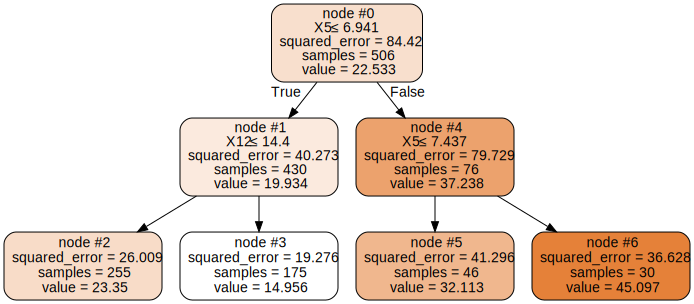

In [3]:
dot_data = sklearn.tree.export_graphviz(orig_model, node_ids=True, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [48]:
# extract the arrays that define the tree
children_left = orig_model.tree_.children_left
children_right = orig_model.tree_.children_right
children_default = children_right.copy() # because sklearn does not use missing values
features = orig_model.tree_.feature
thresholds = orig_model.tree_.threshold
values = orig_model.tree_.value.reshape(orig_model.tree_.value.shape[0], 1)
node_sample_weight = orig_model.tree_.weighted_n_node_samples

print("     children_left", children_left) # note that negative children values mean this is a leaf node
print("    children_right", children_right)
print("  children_default", children_default)
print("          features", features)
print("        thresholds", thresholds.round(3))
print("            values", values.round(3))
print("node_sample_weight", node_sample_weight)

     children_left [ 1  2 -1 -1  5 -1 -1]
    children_right [ 4  3 -1 -1  6 -1 -1]
  children_default [ 4  3 -1 -1  6 -1 -1]
          features [ 5 12 -2 -2  5 -2 -2]
        thresholds [ 6.941 14.4   -2.    -2.     7.437 -2.    -2.   ]
            values [[22.533]
 [19.934]
 [23.35 ]
 [14.956]
 [37.238]
 [32.113]
 [45.097]]
node_sample_weight [506. 430. 255. 175.  76.  46.  30.]


In [49]:
# define a custom tree model
tree_dict = {
    "children_left": children_left,
    "children_right": children_right,
    "children_default": children_default,
    "features": features,
    "thresholds": thresholds,
    "values": values,
    "node_sample_weight": node_sample_weight
}
model = {
    "trees": [tree_dict]
}

In [50]:
explainer = shap.TreeExplainer(model)

In [7]:
# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(explainer.model.predict(X) - orig_model.predict(X)).max() < 1e-4

In [8]:
# make sure the SHAP values sum up to the model output (this is the local accuracy property)
assert np.abs(explainer.expected_value + explainer.shap_values(X).sum(1) - orig_model.predict(X)).max() < 1e-4

## Classification

In [65]:
X,y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

orig_model_clf = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=42)
orig_model_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

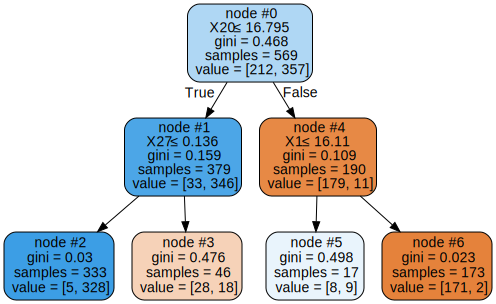

In [66]:
dot_data = sklearn.tree.export_graphviz(orig_model_clf, node_ids=True, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [67]:
# extract the arrays that define the tree
children_left = orig_model_clf.tree_.children_left
children_right = orig_model_clf.tree_.children_right
children_default = children_right.copy() # because sklearn does not use missing values
features = orig_model_clf.tree_.feature
thresholds = orig_model_clf.tree_.threshold
#values = orig_model_clf.tree_.value.reshape(orig_model_clf.tree_.value.shape[0], orig_model_clf.tree_.n_classes[0])
values = np.argmax(orig_model_clf.tree_.value.reshape(orig_model_clf.tree_.value.shape[0], orig_model_clf.tree_.n_classes[0]),axis=1).reshape(orig_model_clf.tree_.value.shape[0], 1)
node_sample_weight = orig_model_clf.tree_.weighted_n_node_samples

print("     children_left", children_left) # note that negative children values mean this is a leaf node
print("    children_right", children_right)
print("  children_default", children_default)
print("          features", features)
print("        thresholds", thresholds.round(3))
print("            values", values.round(3))
print("node_sample_weight", node_sample_weight)

     children_left [ 1  2 -1 -1  5 -1 -1]
    children_right [ 4  3 -1 -1  6 -1 -1]
  children_default [ 4  3 -1 -1  6 -1 -1]
          features [20 27 -2 -2  1 -2 -2]
        thresholds [16.795  0.136 -2.    -2.    16.11  -2.    -2.   ]
            values [[1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]]
node_sample_weight [569. 379. 333.  46. 190.  17. 173.]


In [68]:
# define a custom tree model
tree_dict = {
    "children_left": children_left,
    "children_right": children_right,
    "children_default": children_default,
    "features": features,
    "thresholds": thresholds,
    "values": values,
    "node_sample_weight": node_sample_weight
}
model = {
    "trees": [tree_dict]
}

In [69]:
model

{'trees': [{'children_left': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int64),
   'children_right': array([ 4,  3, -1, -1,  6, -1, -1], dtype=int64),
   'children_default': array([ 4,  3, -1, -1,  6, -1, -1], dtype=int64),
   'features': array([20, 27, -2, -2,  1, -2, -2], dtype=int64),
   'thresholds': array([16.79500008,  0.1358    , -2.        , -2.        , 16.10999966,
          -2.        , -2.        ]),
   'values': array([[1],
          [1],
          [1],
          [0],
          [0],
          [1],
          [0]]),
   'node_sample_weight': array([569., 379., 333.,  46., 190.,  17., 173.])}]}

In [70]:
explainer_clf = shap.TreeExplainer(model)

In [71]:
shaps_sk = explainer.shap_values(X)

In [72]:
explainer_clf.model.predict(X)[:3]

array([1., 0., 0.])

In [73]:
# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(explainer_clf.model.predict(X) - orig_model_clf.predict(X)).max() < 1e-4

In [74]:
# make sure the SHAP values sum up to the model output (this is the local accuracy property)
assert np.abs(explainer_clf.expected_value + explainer_clf.shap_values(X).sum(1) - orig_model_clf.predict(X)).max() < 1e-4

### Classification with probabilities

In [75]:
values = orig_model_clf.tree_.value.reshape(orig_model_clf.tree_.value.shape[0], orig_model_clf.tree_.n_classes[0]).reshape(orig_model_clf.tree_.value.shape[0], 2)
print("            values", values.round(3))

            values [[212. 357.]
 [ 33. 346.]
 [  5. 328.]
 [ 28.  18.]
 [179.  11.]
 [  8.   9.]
 [171.   2.]]


In [76]:
orig_model_clf.tree_.value.reshape(orig_model_clf.tree_.value.shape[0], orig_model_clf.tree_.n_classes[0]).reshape(orig_model_clf.tree_.value.shape[0], 2)

array([[212., 357.],
       [ 33., 346.],
       [  5., 328.],
       [ 28.,  18.],
       [179.,  11.],
       [  8.,   9.],
       [171.,   2.]])

In [106]:
from shap.explainers._tree import SingleTree

In [109]:
# define a custom tree model
tree_dict = {
    "children_left": children_left,
    "children_right": children_right,
    "children_default": children_default,
    "features": features,
    "thresholds": thresholds,
    "values": values,
    "node_sample_weight": node_sample_weight
}
model = {
    "trees": [tree_dict],
    "objective": "binary_crossentropy",
    "tree_output": "probability",
    "input_dtype": np.float32,  # this is what type the model uses the input feature data
    "internal_dtype": np.float64  # this is what type the model uses for values and thresholds
}

In [110]:
explainer_clf = shap.TreeExplainer(model, X, model_output="probability")
explainer_clf.model.predict(X)[:3]

array([[  8.,   9.],
       [171.,   2.],
       [171.,   2.]])

In [85]:
arr = explainer_clf.model.predict(X)[:3]

In [97]:
normalized_vector = np.divide(arr,np.array([np.sum(arr, axis=1),np.sum(arr, axis=1)]).T)

In [98]:
normalized_vector

array([[0.47058824, 0.52941176],
       [0.98843931, 0.01156069],
       [0.98843931, 0.01156069]])

In [99]:
orig_model_clf.predict_proba(X)[:3]

array([[0.47058824, 0.52941176],
       [0.98843931, 0.01156069],
       [0.98843931, 0.01156069]])

In [79]:
np.argmax(explainer_clf.model.predict(X)[:3],axis=1)

array([1, 0, 0])

In [47]:
shaps = explainer_clf.shap_values(X)[1]

In [81]:
assert shaps_sk.all() == shaps.all()

In [84]:
# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
#assert np.abs(explainer_clf.model.predict(X) - orig_model_clf.predict(X)).max() < 1e-4

# make sure the SHAP values sum up to the model output (this is the local accuracy property)
#assert np.abs(explainer_clf.expected_value + explainer_clf.shap_values(X).sum(1) - orig_model_clf.predict(X)).max() < 1e-4